In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# import tflearn

Test by recording sound [y/n]: y
recording...
finished recording


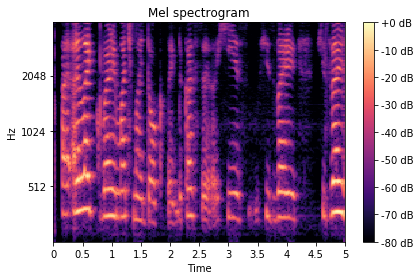

In [2]:
import pyaudio # source ~./bash... unset PYTHONPATH
import wave

import librosa
import librosa.display
import librosa.feature

do_rec = input("Test by recording sound [y/n]: ")

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "test_audio.wav"
IMG_EXT = ".png"

if do_rec.lower() == 'y':
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)
    print ("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print ("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
    
#     plt.figure(figsize=(12, 12))
    y, sr = librosa.load(WAVE_OUTPUT_FILENAME)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)
    librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                            fmax=4000)
    output_filename = WAVE_OUTPUT_FILENAME[:-4] + "_spec" + IMG_EXT
    plt.savefig(output_filename, bbox_inches='tight', pad_inches = 0)
    librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                             y_axis='mel', fmax=4000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()

In [3]:
'''
# Convert audio files to spectrograms:



directory = "../test_audio/"

plt.figure(figsize=(12, 12))
for filename in os.listdir(directory):

    if filename[:1] != '.':
        path = os.path.join(directory, filename)

        y, sr = librosa.load(path)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)
        librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                                fmax=4000)
        output_filename = "../test_spectrograms/" + filename[:-4] + "_spec" + IMG_EXT
        plt.savefig(output_filename, bbox_inches='tight', pad_inches = 0)
'''

'\n# Convert audio files to spectrograms:\n\n\n\ndirectory = "../test_audio/"\n\nplt.figure(figsize=(12, 12))\nfor filename in os.listdir(directory):\n\n    if filename[:1] != \'.\':\n        path = os.path.join(directory, filename)\n\n        y, sr = librosa.load(path)\n        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)\n        librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),\n                                fmax=4000)\n        output_filename = "../test_spectrograms/" + filename[:-4] + "_spec" + IMG_EXT\n        plt.savefig(output_filename, bbox_inches=\'tight\', pad_inches = 0)\n'

In [22]:
from PIL import Image
import numpy as np
import scipy.ndimage

import PIL




#Returns numpy image at size imageSize*imageSize
def getProcessedData(img,imageSize, grayscale):
    numchannels = 4
    if grayscale:
        numchannels = 2            
    img = img.resize((imageSize,imageSize), resample=Image.ANTIALIAS)
    imgData = np.array(img, dtype=np.uint8).reshape(img.size[0], img.size[1], numchannels)


    imgData = imgData[:, :, :-1]
    imgData = imgData/255.
    return imgData

#Returns numpy image at size imageSize*imageSize
def getImageData(filename,imageSize, grayscale):
    if grayscale:
        img = Image.open(filename).convert('LA')
    else:
        img = Image.open(filename)
    imgData = getProcessedData(img, imageSize, grayscale)
    return imgData

In [47]:
from random import shuffle
import pickle

directory = "../test_spectrograms/"

def createDataset(size, validationRatio, testRatio, grayscale):
    data = []
    numchannels = 3
    if grayscale:
        numchannels = 1
    count = 1
    #Add data (X,y)
    for filename in os.listdir(directory):
        if filename[:1] != '.':
            path = os.path.join(directory, filename)
            imgData = getImageData(path, size, grayscale)
            label = 1.
            if filename[:4] == "nois" or filename[:4] == "audi" or filename[:4] == "myno":
                label = 0.
            data.append((imgData,label))

    #Shuffle data
    shuffle(data)

    #Extract X and y
    X,y = zip(*data)

    #Split data
    validationNb = int(len(X)*validationRatio)
    testNb = int(len(X)*testRatio)
    trainNb = len(X)-(validationNb + testNb)
    print(validationNb, testNb, trainNb)

    #Prepare for Tflearn at the same time
    train_X = np.array(X[:trainNb]).reshape([-1, size, size, 1])
    train_y = np.array(y[:trainNb])
    validation_X = np.array(X[trainNb:trainNb+validationNb]).reshape([-1, size, size, 1])
    validation_y = np.array(y[trainNb:trainNb+validationNb])
    test_X = np.array(X[-testNb:]).reshape([-1, size, size, 1])
    test_y = np.array(y[-testNb:])
    print("Dataset created!")

    return train_X, train_y, validation_X, validation_y, test_X, test_y

#Saves dataset
def saveDataset(train_X, train_y, validation_X, validation_y, test_X, test_y):

    #SaveDataset
    print("Saving dataset... ")
    datasetName = "main"
    pickle.dump(train_X, open("train_X_{}.p".format(datasetName), "wb" ))
    pickle.dump(train_y, open("train_y_{}.p".format(datasetName), "wb" ))
    pickle.dump(validation_X, open("validation_X_{}.p".format(datasetName), "wb" ))
    pickle.dump(validation_y, open("validation_y_{}.p".format(datasetName), "wb" ))
    pickle.dump(test_X, open("test_X_{}.p".format(datasetName), "wb" ))
    pickle.dump(test_y, open("test_y_{}.p".format(datasetName), "wb" ))
    print("Dataset saved!")
    



In [48]:
train_X, train_y, validation_X, validation_y, test_X, test_y = createDataset(128, 0.3, 0.1, True)
# print(np.shape(train_X), np.shape(train_y), np.shape(validation_X), np.shape(validation_y), np.shape(test_X), np.shape(test_y))
# print(np.unique(train_y))

train_y = np.reshape(train_y, (-1, 1))
test_y = np.reshape(test_y, (-1, 1))
validation_y = np.reshape(validation_y, (-1, 1))
# print(np.shape(train_X), np.shape(train_y), np.shape(validation_X), np.shape(validation_y), np.shape(test_X), np.shape(test_y))
saveDataset(train_X, train_y, validation_X, validation_y, test_X, test_y)

data size (1998, 2)
data size (1998, 2)
X size (1998, 128, 128, 1)
y size (1998,)
599 199 1200
    Dataset created!
(1200, 128, 128, 1) (1200,) (599, 128, 128, 1) (599,) (199, 128, 128, 1) (199,)
[ 0.  1.]
(1200, 128, 128, 1) (1200, 1) (599, 128, 128, 1) (599, 1) (199, 128, 128, 1) (199, 1)
[+] Saving dataset... 
    Dataset saved! ✅💾


In [13]:
import pickle
def loadDataset():
    #Load existing
    
    datasetName = "main"
    print("Loading training and validation datasets... ")
    train_X = pickle.load(open("train_X_{}.p".format(datasetName), "rb" ))
    train_y = pickle.load(open("train_y_{}.p".format(datasetName), "rb" ))
    validation_X = pickle.load(open("validation_X_{}.p".format(datasetName), "rb" ))
    validation_y = pickle.load(open("validation_y_{}.p".format(datasetName), "rb" ))
    print("Training and validation datasets loaded!")
    print("Loading testing dataset... ")
    test_X = pickle.load(open("test_X_{}.p".format(datasetName), "rb" ))
    test_y = pickle.load(open("test_y_{}.p".format(datasetName), "rb" ))
    print("Testing dataset loaded!")
    return train_X, train_y, validation_X, validation_y, test_X, test_y

train_X, train_y, validation_X, validation_y, test_X, test_y = loadDataset()

# print(np.shape(train_X), np.shape(train_y), np.shape(validation_X), np.shape(validation_y), np.shape(test_X), np.shape(test_y))


Loading training and validation datasets... 
Training and validation datasets loaded!
Loading testing dataset... 
Testing dataset loaded!


In [31]:
xstd = np.std(train_X)
xmean = np.mean(train_X)
Xtr = (train_X - xmean) / xstd
Xts = (test_X - xmean) / xstd
Xval = (validation_X - xmean) / xstd

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [33]:
import keras.backend as K
K.clear_session()

In [34]:
input_shape = Xtr.shape[1:]
print(input_shape)

(128, 128, 1)


In [35]:
model = Sequential()
model.add(Conv2D(input_shape=input_shape, 
                kernel_size=(16,16),
                filters=8,activation="relu"))
model.add(MaxPooling2D(pool_size=(16,16)))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 113, 113, 8)       2056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 393       
Total params: 2,449
Trainable params: 2,449
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
model.fit(Xtr, train_y, epochs=10, validation_data=(Xval, validation_y))

Train on 1200 samples, validate on 599 samples
Epoch 1/10
1200/1200 [==============================] - 63s - loss: 0.3394 - acc: 0.8400 - val_loss: 0.1463 - val_acc: 0.9482
Epoch 2/10
1200/1200 [==============================] - 52s - loss: 0.1155 - acc: 0.9567 - val_loss: 0.1074 - val_acc: 0.9616
Epoch 3/10
1200/1200 [==============================] - 49s - loss: 0.0831 - acc: 0.9708 - val_loss: 0.0797 - val_acc: 0.9766
Epoch 4/10
1200/1200 [==============================] - 48s - loss: 0.0616 - acc: 0.9842 - val_loss: 0.0654 - val_acc: 0.9816
Epoch 5/10
1200/1200 [==============================] - 48s - loss: 0.0422 - acc: 0.9883 - val_loss: 0.0572 - val_acc: 0.9833
Epoch 6/10
1200/1200 [==============================] - 52s - loss: 0.0340 - acc: 0.9942 - val_loss: 0.0477 - val_acc: 0.9866
Epoch 7/10
1200/1200 [==============================] - 49s - loss: 0.0275 - acc: 0.9933 - val_loss: 0.0434 - val_acc: 0.9883
Epoch 8/10
1200/1200 [==============================] - 49s - loss: 0.0

In [38]:
from keras.models import load_model

model.save('my_cnn_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_cnn_model.h5')

Test by recording sound [y/n]: y
recording...
finished recording


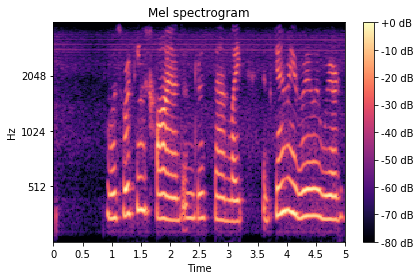

In [49]:
import pyaudio # source ~./bash... unset PYTHONPATH
import wave

import librosa
import librosa.display
import librosa.feature

do_rec = input("Test by recording sound [y/n]: ")

FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 8000
CHUNK = 1024
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "test_audio.wav"
IMG_EXT = ".png"

if do_rec.lower() == 'y':
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)
    print ("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print ("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()
    
#     plt.figure(figsize=(12, 12))
    y, sr = librosa.load(WAVE_OUTPUT_FILENAME)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=4000)
    librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                            fmax=4000)
    output_filename = WAVE_OUTPUT_FILENAME[:-4] + "_spec" + IMG_EXT
    plt.savefig(output_filename, bbox_inches='tight', pad_inches = 0)
    librosa.display.specshow(librosa.logamplitude(S,ref_power=np.max),
                             y_axis='mel', fmax=4000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()

In [50]:
path = "./test_audio_spec.png"
imgData = getImageData(path, 128, True)


X_predict = imgData
print(np.shape(X_predict))
# Xpr = (X_predict - xmean) / xstd

# X_predict = np.reshape(Xpr, (1 , 128, 128, 1))

X_predict = np.reshape(X_predict, (1 , 128, 128, 1))
# print(np.shape(X_predict))
# # model.load('musicDNN.tflearn')
# print(test_y)
prediction = model.predict(X_predict)[0][0]
if prediction > 0.5:
    print("legit call")
else:
    print("pocket dial")
print(prediction)
print(model.predict(X_predict))

(128, 128, 1)
pocket dial
0.134901
[[ 0.13490103]]
